In [ ]:
import tensorflow as tf
import os #for file management
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = r'/content/drive/MyDrive/Final Train Data/Pest' #  dataset directory

Mounted at /content/drive


In [ ]:

IMAGE_SIZE = 224

BATCH_SIZE = 64
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=30,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training'
)


val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation'
)


IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3) 
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)



Found 1741 images belonging to 6 classes.
Found 433 images belonging to 6 classes.
9406464/9406464 [==============================] - 0s 0us/step


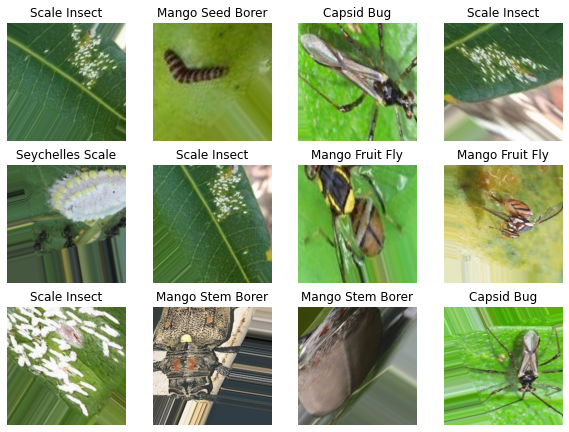

In [ ]:

# get the first batch of images
x_batch, y_batch = next(train_generator)

# get the class names from the generator
class_names = list(train_generator.class_indices.keys())

# plot the first 9 images in the batch
plt.figure(figsize=(10, 10))
for i in range(12):
    # get the true class of the image
    true_class = class_names[y_batch[i].argmax()]

    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(x_batch[i])
    plt.title(true_class)
    plt.axis("off")
plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 64)          737344    
                                                                 
 batch_normalization (BatchN  (None, 5, 5, 64)         256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 2, 64)          0         
                                                        

In [ ]:
#Next we have to create a labels.txt file that will hold all our labels (important for Flutter)
print(train_generator.class_indices) #prints every single key and class of that dataset
labels = '\n'.join(sorted(train_generator.class_indices.keys())) #print all these keys as a list of labels into a text file called labels.txt
with open('pest.txt', 'w') as f: #writes to the labels.txt file, and if it doesnt exists, it creates one, and if it does exist, it will overrite it. (thats what 'w' is for)
    f.write(labels)
    

{'Capsid Bug': 0, 'Mango Fruit Fly': 1, 'Mango Seed Borer': 2, 'Mango Stem Borer': 3, 'Scale Insect': 4, 'Seychelles Scale': 5}


In [ ]:
epochs = 10 #higher the epochs, more accurate is the NN, however it could cause Overfitting, if too high
history = model.fit(
    train_generator, 
    epochs = epochs, 
    validation_data=val_generator
)

Epoch 1/10
28/28 [==============================] - 707s 26s/step - loss: 0.8022 - accuracy: 0.7209 - precision: 0.8010 - recall: 0.6611 - val_loss: 1.4061 - val_accuracy: 0.6952 - val_precision: 0.7188 - val_recall: 0.6905
Epoch 2/10
28/28 [==============================] - 128s 5s/step - loss: 0.2624 - accuracy: 0.9173 - precision: 0.9403 - recall: 0.8955 - val_loss: 0.5090 - val_accuracy: 0.8291 - val_precision: 0.8698 - val_recall: 0.8176
Epoch 3/10
28/28 [==============================] - 157s 6s/step - loss: 0.1443 - accuracy: 0.9512 - precision: 0.9646 - recall: 0.9403 - val_loss: 0.4760 - val_accuracy: 0.8476 - val_precision: 0.8589 - val_recall: 0.8291
Epoch 4/10
28/28 [==============================] - 145s 5s/step - loss: 0.1115 - accuracy: 0.9604 - precision: 0.9674 - recall: 0.9540 - val_loss: 0.5610 - val_accuracy: 0.8152 - val_precision: 0.8321 - val_recall: 0.8014
Epoch 5/10
28/28 [==============================] - 145s 5s/step - loss: 0.1093 - accuracy: 0.9621 - precis

In [ ]:
#now that we have our neural network trained with tensorflow and keras, we can export it 
saved_model_dir = '' #means current directory
tf.saved_model.save(model, saved_model_dir) #saves to the current directory

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) 
tflite_model = converter.convert() #converts our model into a .tflite model which flutter uses for ondevice machine learning

with open('pest.tflite', 'wb') as f: #to write the converted model into a file, written as binary so add 'wb' instead of 'w'
  f.write(tflite_model)

In [ ]:
#use below codes to download files locally if using google colab
from google.colab import files
files.download('pest.tflite')
files.download('pest.txt')

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']

print(acc)
print(val_acc)
print(loss)
print(val_loss)
print(precision)
print(val_precision)
print(recall)
print(val_recall )

NameError: ignored

In [ ]:
final_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_precision = history.history['precision'][-1]
final_val_precision = history.history['val_precision'][-1]
final_recall = history.history['recall'][-1]
final_val_recall = history.history['val_recall'][-1]

print("final_acc:",final_acc)
print("final_val_acc:",final_val_acc)
print("final_loss:",final_loss)
print("final_val_loss:", final_val_loss)
print("final_precision:" ,final_precision)
print("final_val_precision:",final_val_precision)
print("final_recall: ",final_recall)
print("final_recall: ", final_val_recall)